   # Cover Type Classification
   
   ### Objective: Build a deep learning model to predict the forest cover type from different cartographic variables.
   ### Given: 
       1. Cover Types: ['Spruce/Fir', 'Lodgepole Pine','Ponderosa Pine', 'Cottonwood/Willow','Aspen', 'Douglas-fir', 'Krummholz']
       2. A csv file ('cover_data.csv') that contains 581012 observations. Each observation has 55 columns (54 features and the last one being the class).
   ### Assumption(s):
       1. There are no separate test dataset. So, one must hold-out a small percentage of given input as test data.
       2. There is no information about the use of predictions. Hence, we do not know how what to focus on (precision or recall). Generally, it's a good idea to have both scores 'high'.
   ### Expected output: 
       1. A good model.
       2. Model performance over epochs (accuracy, loss plots)
       3. Some classification metrics (heatmap of confusion-matrix, classification-report etc).
       4. Conclusions, thoughts and ways to improve classification accuracy.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tensorflow as tf
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import CategoricalAccuracy, AUC, Accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [9]:
# Disable those annoying warnings
tf.get_logger().setLevel('ERROR')

# Turn off GPU usage for tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

In [10]:
raw_df = pd.read_csv('cover_data.csv')
raw_df.head(10)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
5,2579,132,6,300,-15,67,230,237,140,6031,...,0,0,0,0,0,0,0,0,0,2
6,2606,45,7,270,5,633,222,225,138,6256,...,0,0,0,0,0,0,0,0,0,5
7,2605,49,4,234,7,573,222,230,144,6228,...,0,0,0,0,0,0,0,0,0,5
8,2617,45,9,240,56,666,223,221,133,6244,...,0,0,0,0,0,0,0,0,0,5
9,2612,59,10,247,11,636,228,219,124,6230,...,0,0,0,0,0,0,0,0,0,5


In [11]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

In [12]:
raw_df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


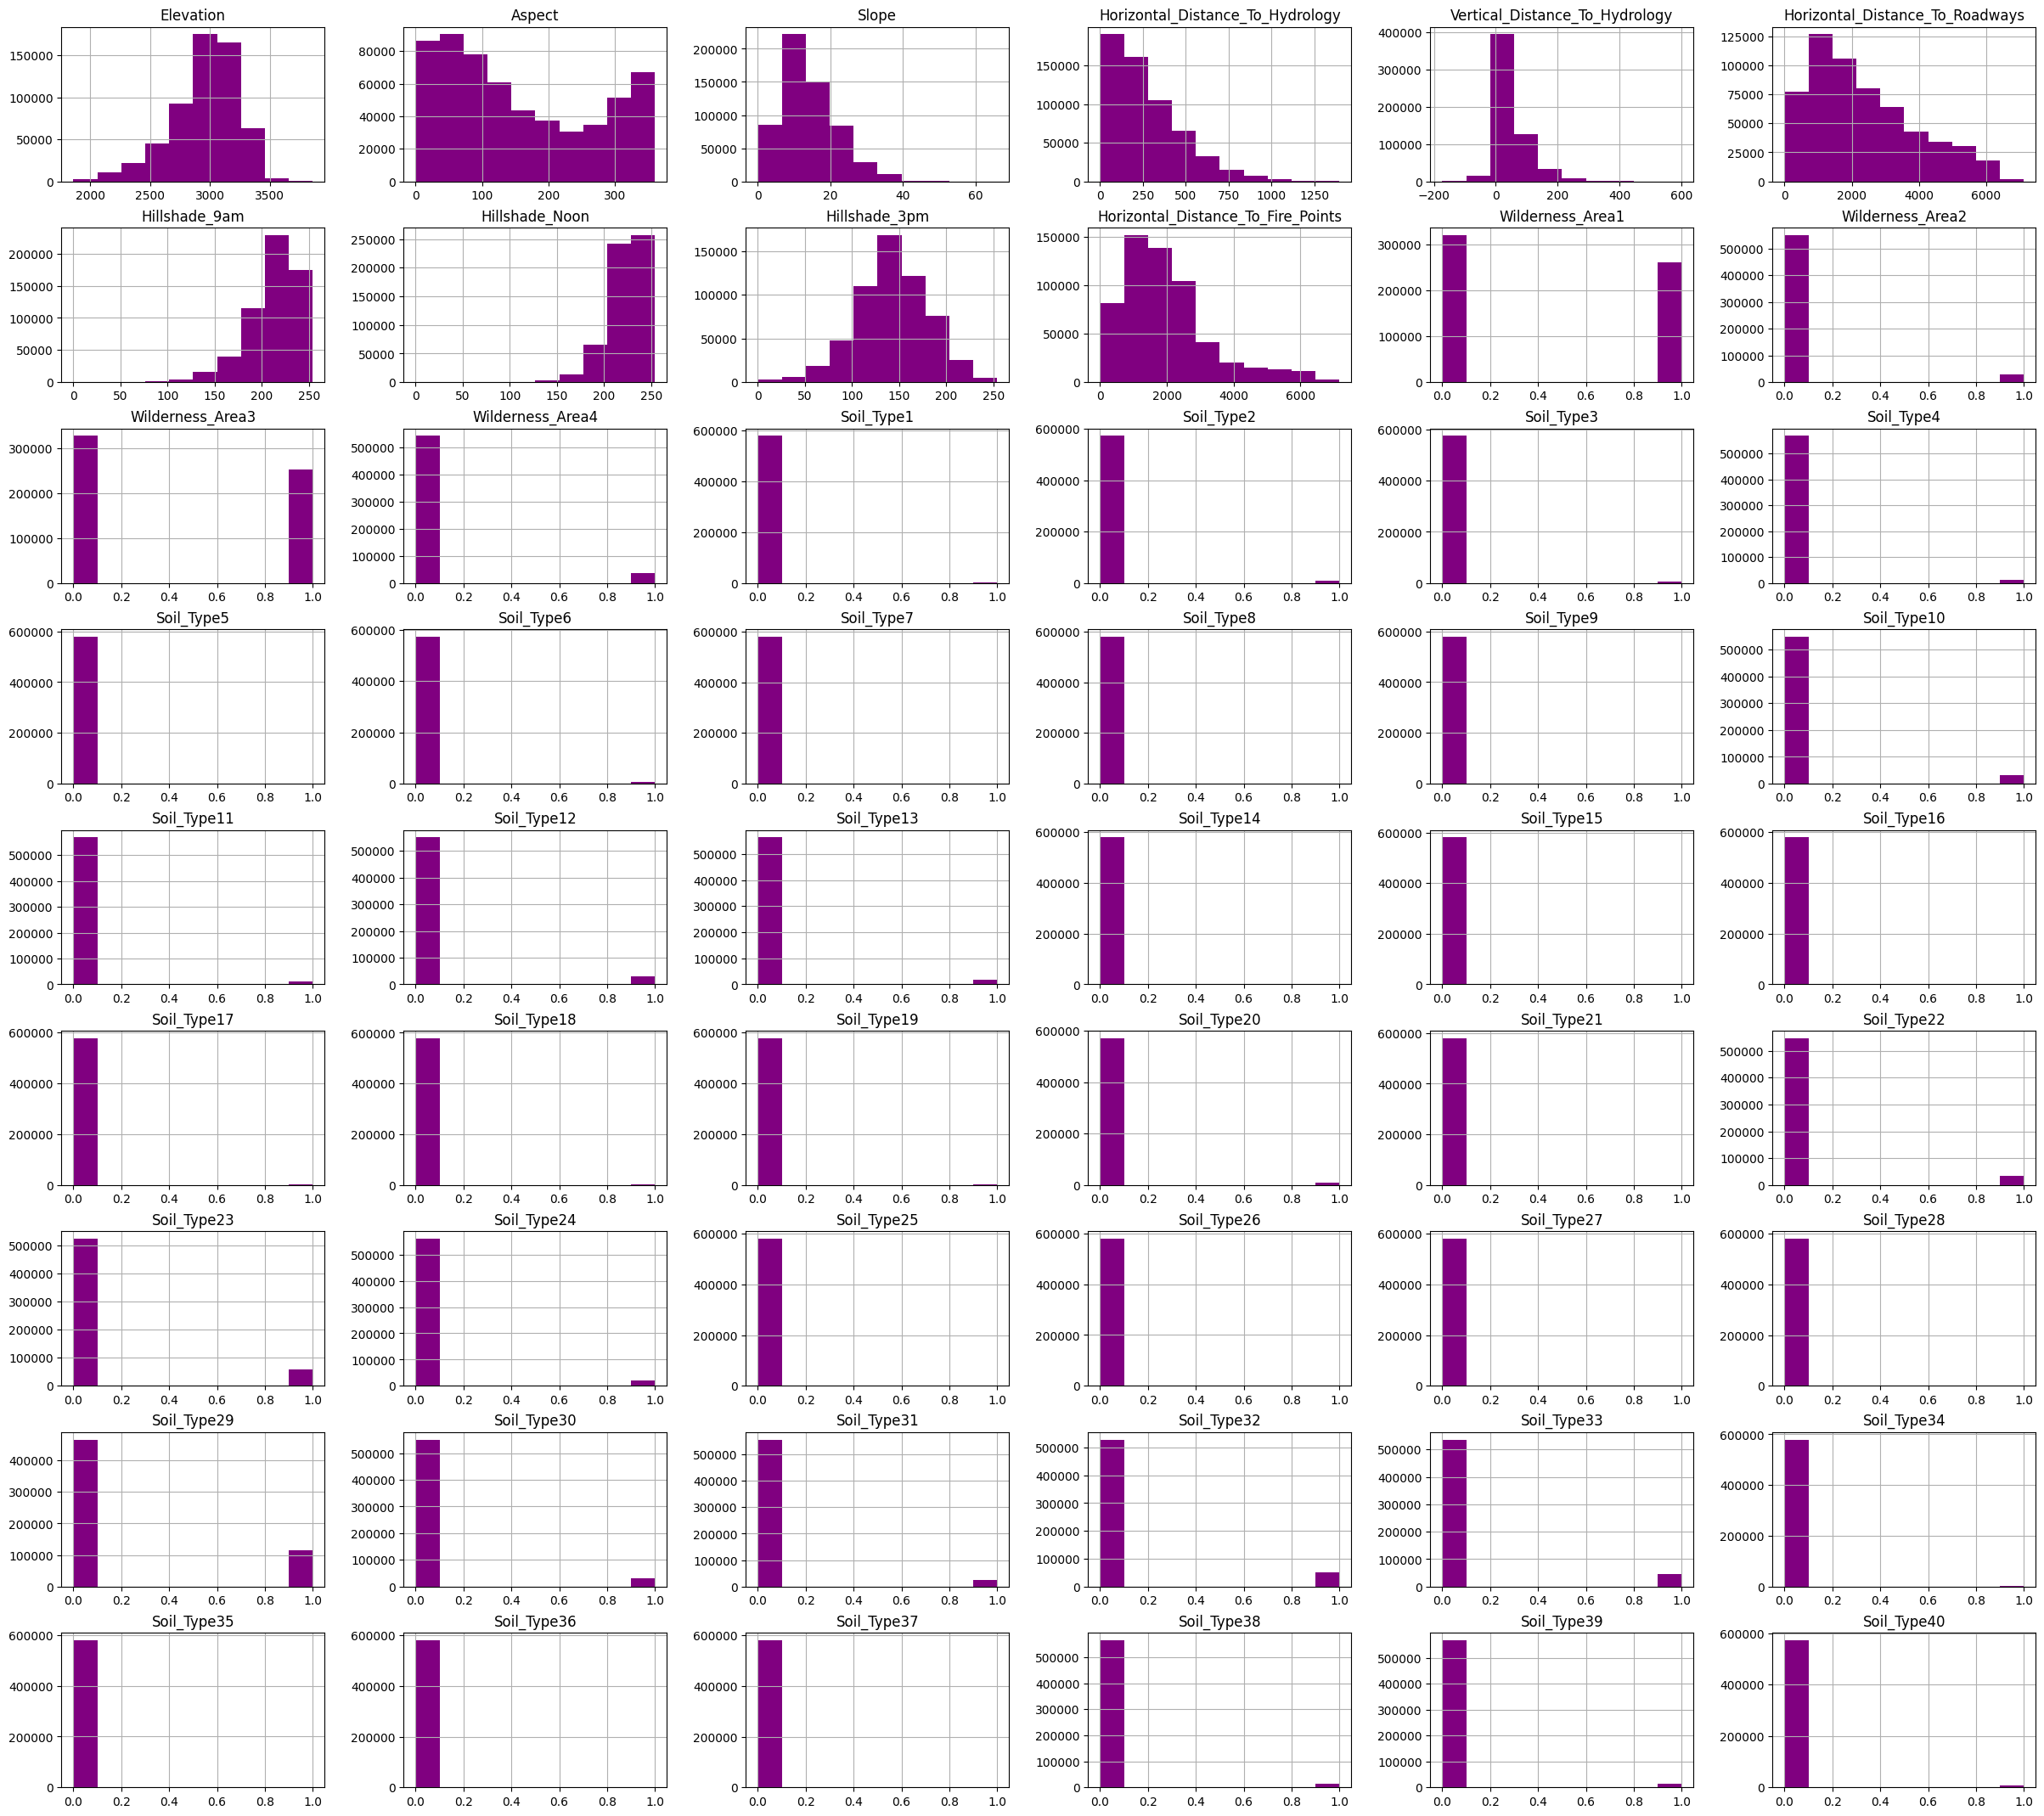

In [13]:
raw_df.hist(figsize=(30,30),column=raw_df.drop(columns=['class']).columns,color='purple',layout=(10,6))
plt.show()

Counter({2: 283301, 1: 211840, 3: 35754, 7: 20510, 6: 17367, 5: 9493, 4: 2747})


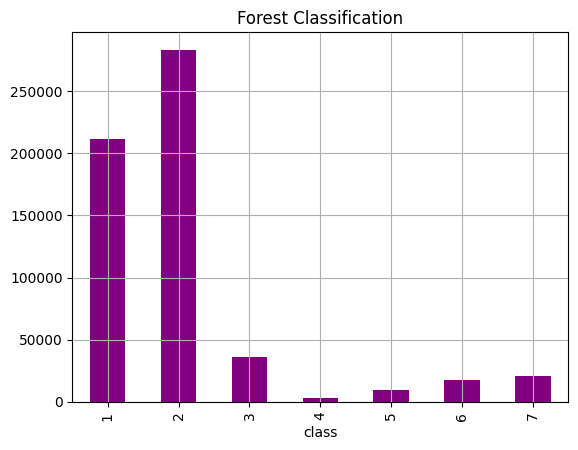

In [14]:
result = raw_df.groupby(raw_df['class']).size()
print(Counter(raw_df["class"]))
ax = result.plot(kind='bar',color='purple',title='Forest Classification')
ax.grid()

In [15]:
correlation = round(raw_df.corr(),4)
correlation

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
Elevation,1.0000,0.0157,-0.2427,0.3062,0.0933,0.3656,0.1122,0.2059,0.0591,0.1480,...,0.1671,0.0706,0.0117,0.0830,0.0211,0.0354,0.2172,0.1936,0.2126,-0.2696
Aspect,0.0157,1.0000,0.0787,0.0174,0.0703,0.0251,-0.5793,0.3361,0.6469,-0.1092,...,0.0562,0.0192,0.0109,-0.0220,0.0023,-0.0204,0.0177,0.0083,-0.0059,0.0171
Slope,-0.2427,0.0787,1.0000,-0.0106,0.2750,-0.2159,-0.3272,-0.5269,-0.1759,-0.1857,...,-0.1335,0.2089,-0.0110,-0.0222,0.0029,0.0078,-0.0722,0.0936,0.0256,0.1483
Horizontal_Distance_To_Hydrology,0.3062,0.0174,-0.0106,1.0000,0.6062,0.0720,-0.0271,0.0468,0.0523,0.0519,...,0.1272,0.1012,0.0703,-0.0052,0.0334,-0.0068,0.0430,0.0319,0.1470,-0.0203
Vertical_Distance_To_Hydrology,0.0933,0.0703,0.2750,0.6062,1.0000,-0.0464,-0.1663,-0.1110,0.0349,-0.0699,...,0.0398,0.1671,0.0603,-0.0061,0.0130,-0.0075,-0.0086,0.0439,0.1790,0.0817
Horizontal_Distance_To_Roadways,0.3656,0.0251,-0.2159,0.0720,-0.0464,1.0000,0.0343,0.1895,0.1061,0.3316,...,-0.0890,-0.0828,0.0064,-0.0030,0.0076,0.0163,0.0798,0.0338,0.0161,-0.1534
Hillshade_9am,0.1122,-0.5793,-0.3272,-0.0271,-0.1663,0.0343,1.0000,0.0100,-0.7803,0.1327,...,0.0065,-0.0644,0.0072,0.0279,0.0079,0.0103,0.0151,-0.0296,-0.0000,-0.0354
Hillshade_Noon,0.2059,0.3361,-0.5269,0.0468,-0.1110,0.1895,0.0100,1.0000,0.5943,0.0573,...,0.1254,-0.0862,0.0431,0.0059,0.0162,-0.0227,0.0430,-0.0720,-0.0402,-0.0964
Hillshade_3pm,0.0591,0.6469,-0.1759,0.0523,0.0349,0.1061,-0.7803,0.5943,1.0000,-0.0480,...,0.0831,-0.0244,0.0178,-0.0165,0.0013,-0.0221,0.0222,-0.0290,-0.0243,-0.0483
Horizontal_Distance_To_Fire_Points,0.1480,-0.1092,-0.1857,0.0519,-0.0699,0.3316,0.1327,0.0573,-0.0480,1.0000,...,-0.0900,-0.0591,-0.0351,-0.0001,-0.0106,0.0042,-0.0197,-0.0033,0.0089,-0.1089


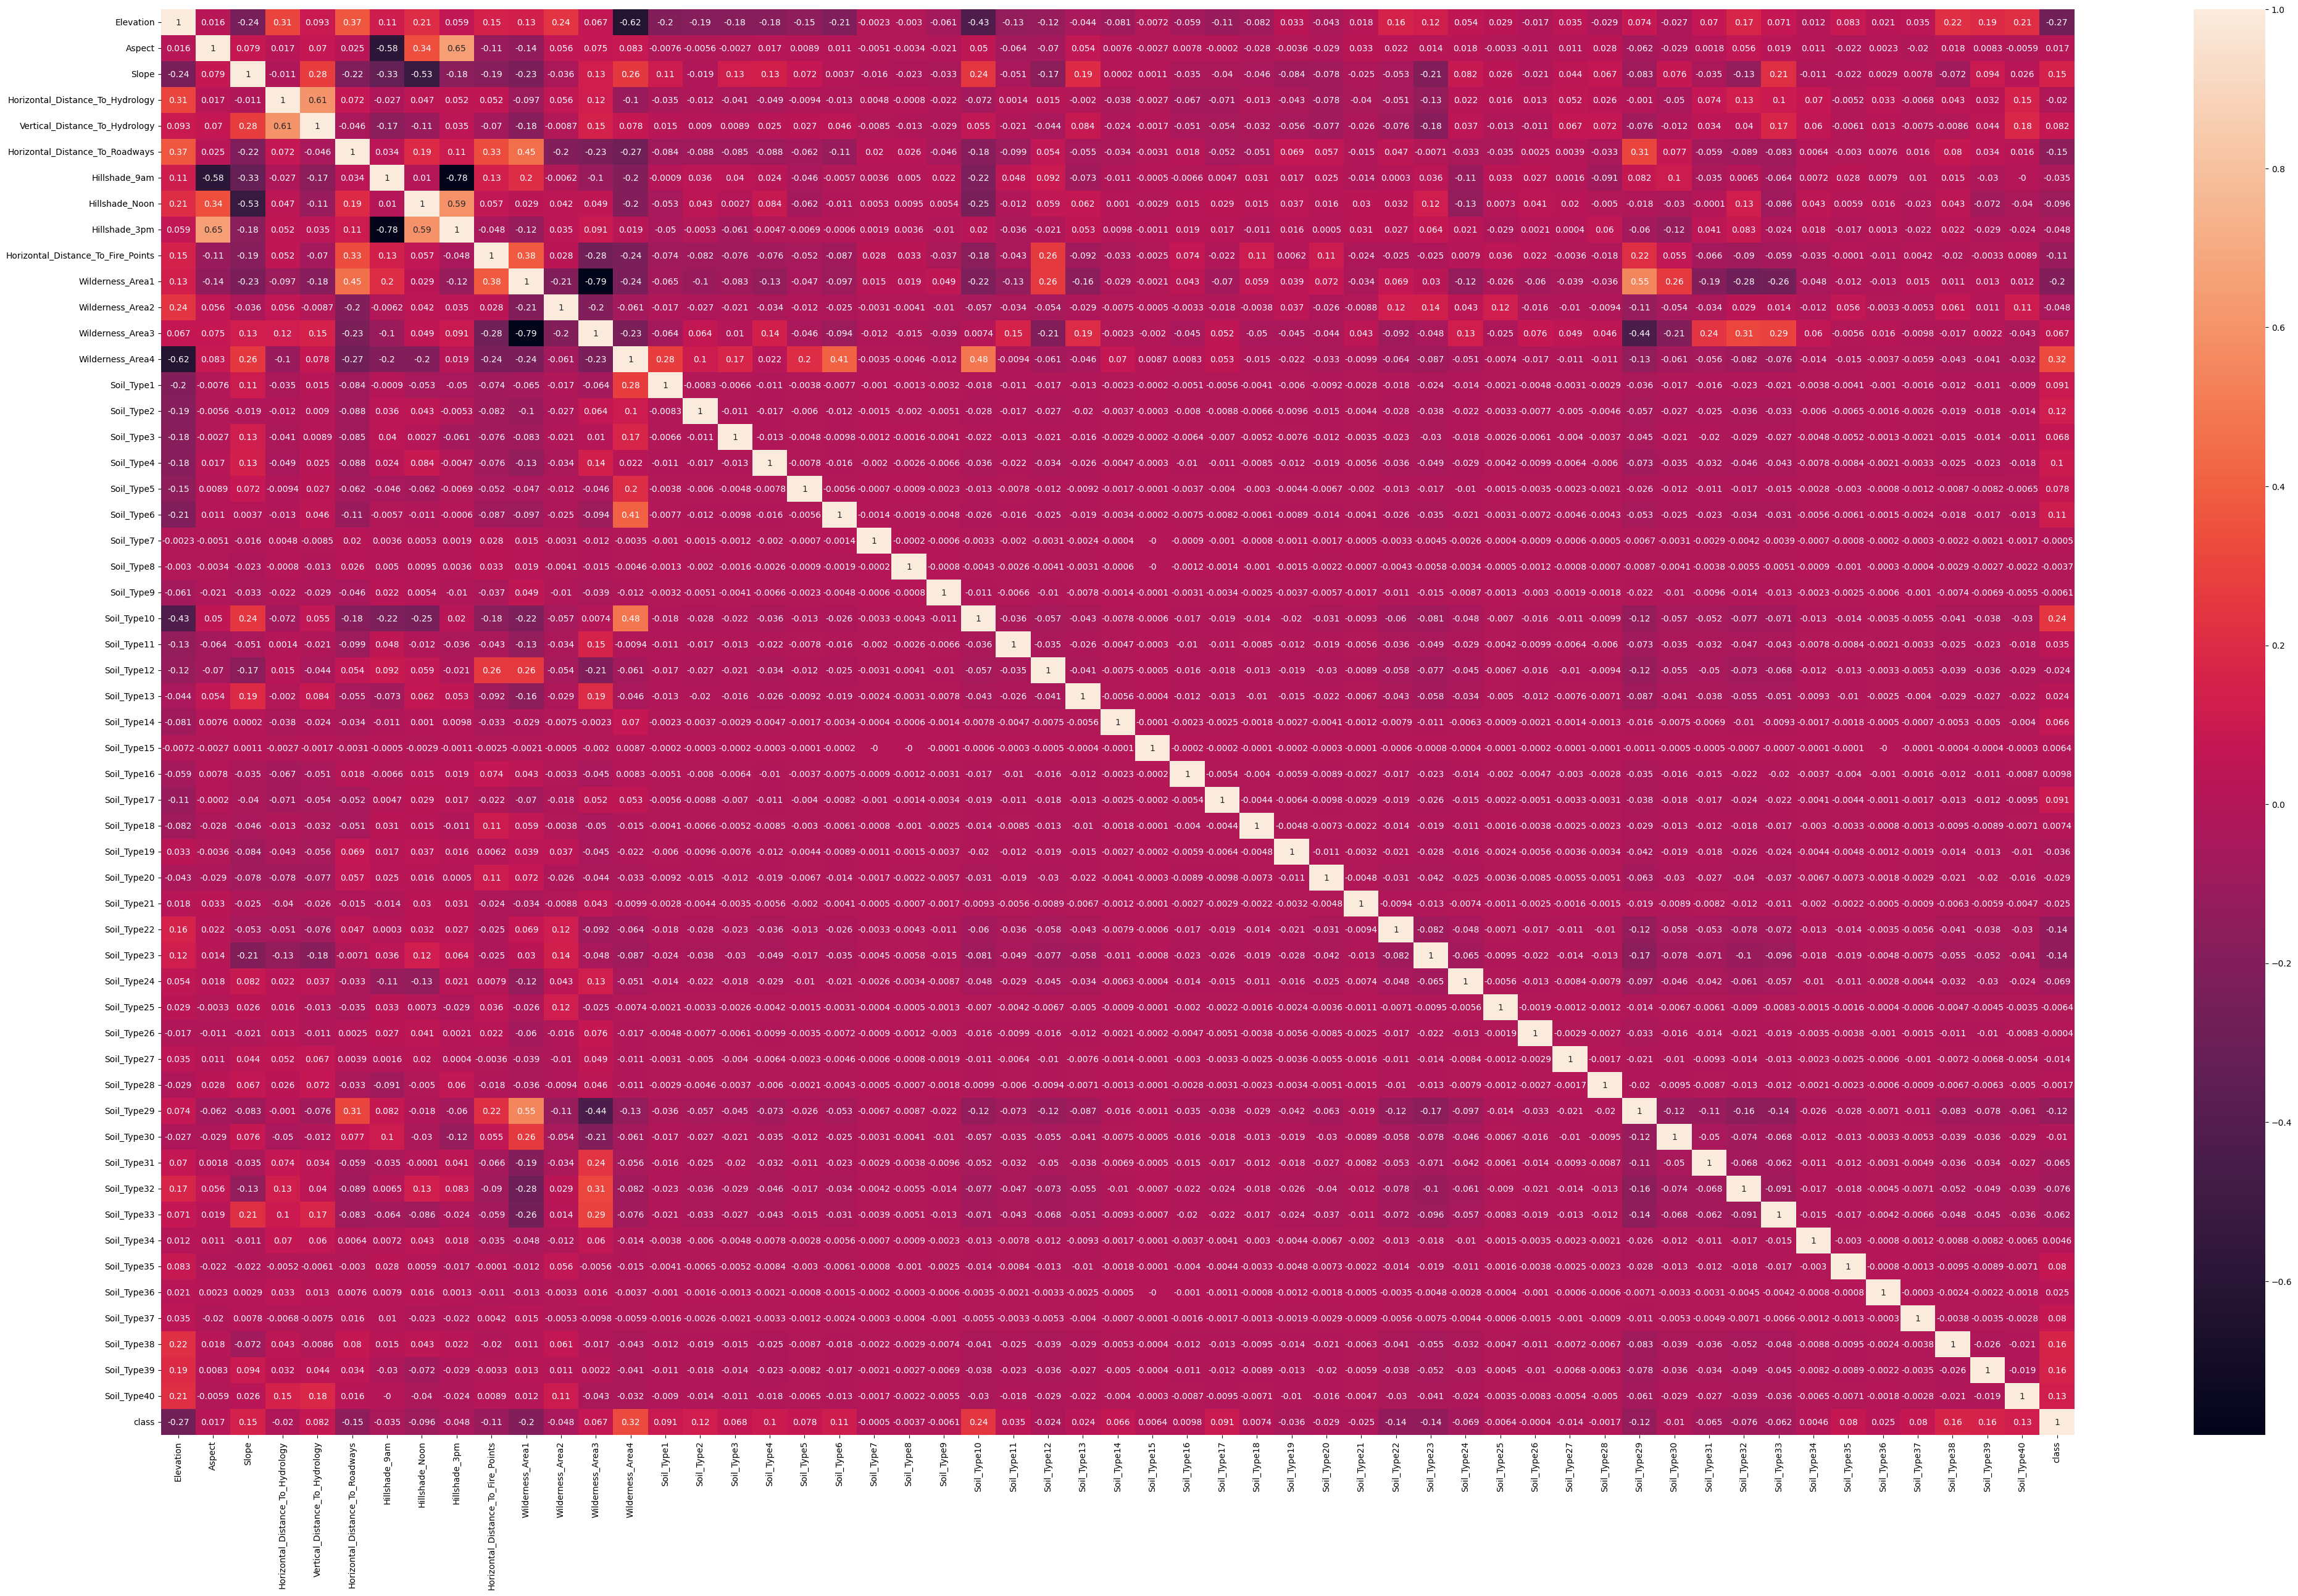

Hillshade_3pm Hillshade_9am -0.7803
Wilderness_Area3 Wilderness_Area1 -0.7936
The coefficient of other features not greater than 0.7


In [16]:
plt.figure(figsize=(50,30))
sns.heatmap(correlation, annot=True)
plt.show()

# Loop over bottom diagonal of correlation matrix
for i in range(len(correlation.columns)):
    for j in range(i):
        # Print variables with high correlation
        if abs(correlation.iloc[i, j]) > 0.7:
            print(correlation.columns[i], correlation.columns[j], correlation.iloc[i, j])
else:
    print('The coefficient of other features not greater than 0.7')

                                       class
Elevation                          -0.269554
Aspect                              0.017080
Slope                               0.148285
Horizontal_Distance_To_Hydrology   -0.020317
Vertical_Distance_To_Hydrology      0.081664
Horizontal_Distance_To_Roadways    -0.153450
Hillshade_9am                      -0.035415
Hillshade_Noon                     -0.096426
Hillshade_3pm                      -0.048290
Horizontal_Distance_To_Fire_Points -0.108936
Wilderness_Area1                   -0.203913
Wilderness_Area2                   -0.048059
Wilderness_Area3                    0.066846
Wilderness_Area4                    0.323200
Soil_Type1                          0.090828
Soil_Type2                          0.118135
Soil_Type3                          0.068064
Soil_Type4                          0.099672
Soil_Type5                          0.077890
Soil_Type6                          0.112958
Soil_Type7                         -0.000496
Soil_Type8

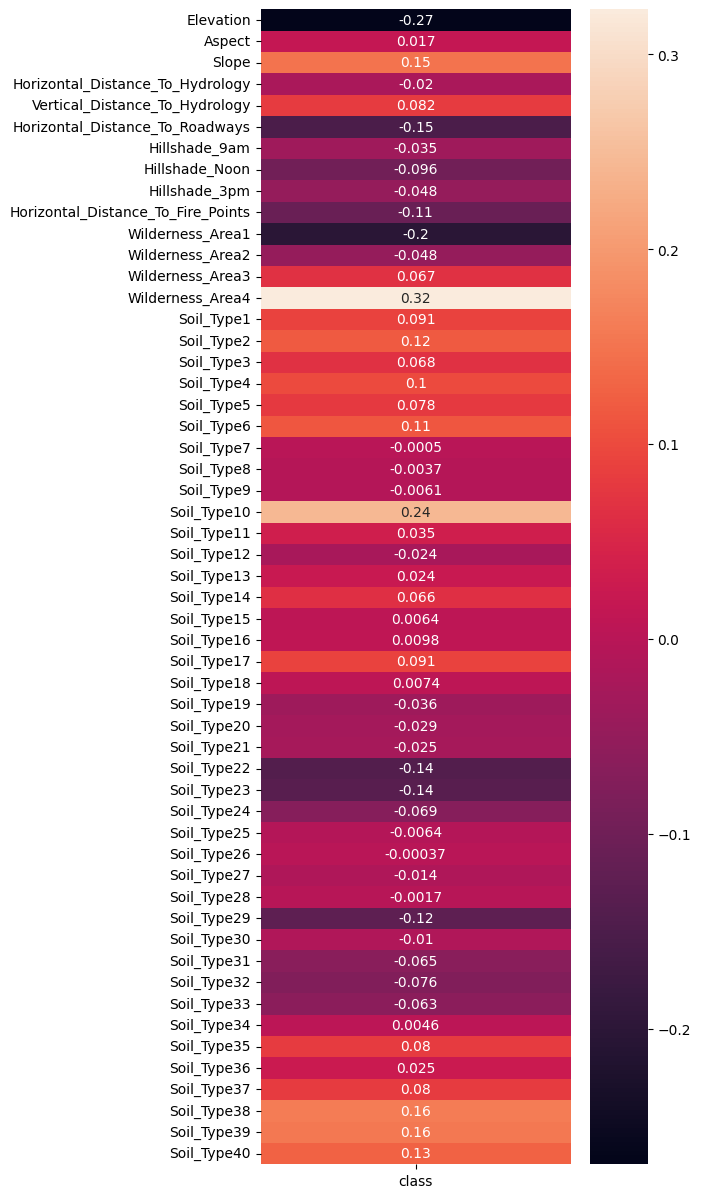

In [17]:
correlation_features = raw_df.corr()
correlation_target =  correlation_features[['class']].drop(labels=['class'])
print(correlation_target)
plt.figure(figsize=(5,15))
sns.heatmap(correlation_target, annot=True)
plt.show()

### Define some helper functions

In [18]:
def prep_data(raw_df, features, label):
    """
    Prepare data that can be readily consumed by ML/DL algorithms.
    - separate features from class variables
    - split into training and testing dataset
    - scale numerical data
    
    param: a dataframe of input data
    output: X_train_normalized, X_test_normalized, y_train, y_test
    """
    X = raw_df[features]
    y = raw_df[label]

    # Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

    # normalize data
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    return X_train_normalized, X_test_normalized, y_train, y_test

In [19]:
def build_model(num_features):
    """
    Build the model architecture (and compile it).
    input: number of features
    output: Keras model object.
    """
    classifier = Sequential()
    classifier.add(Dense(256, input_dim=num_features, activation='relu'))
#     classifier.add(Dropout(0.3))
    classifier.add(Dense(128, activation='relu'))
#     classifier.add(layers.Dropout(0.3))
    classifier.add(Dense(64, activation='softmax'))
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Plot the model
    plot_model(classifier, to_file='classifier.png', show_shapes=True)
    return classifier

In [20]:
def plot_heatmap(class_names, y_pred, y_test):

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    plt.show()
    # Save the heatmap to file
#     heatmapfig = heatmap.get_figure()
#     heatmapfig.savefig(f'../output/confusion_matrix.png')

In [21]:
def plot_history(history, param):

    if param == 'acc':
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.grid()
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Training', 'Validation'], loc='upper left')
        plt.show()
    elif param == 'loss':
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.grid()
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training', 'Validation'], loc='upper right')
        plt.show()

### The main function below drives the entire code. It prepares the dataset, builds a model with appropriate parameters, evaluates the model and predicts on the test data. Finally, plots some performance metrics.

In [22]:
def main():

    # EDA
    # Uncomment the below two lines to run EDA. Takes > 10 min to run.
    #my_report = sv.analyze(raw_df)
    #my_report.show_html()
    raw_df = pd.read_csv('cover_data.csv')
    cols = raw_df.drop(columns=['Hillshade_9am','Wilderness_Area3','Soil_Type7','Soil_Type8','Soil_Type9',
                                'Soil_Type15','Soil_Type16','Soil_Type16','Soil_Type25','Soil_Type26','Soil_Type28',
                                 'Soil_Type34']).columns.tolist()
    
    features, label = cols[:-1], cols[-1]
    X_train, X_test, y_train, y_test = prep_data(raw_df,features,label)

    # Build a DL model
    num_features = len(features)
    model = build_model(num_features)

    print("Summary report of Keras classifier:")
    model.summary()

    num_epochs = 100
    batch_size = 1024
    earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3)
    history = model.fit(X_train,
                        y_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        callbacks=[earlystop_callback],
                        validation_split=0.1,
                        verbose=1)

    plot_history(history, 'acc')
    plot_history(history, 'loss')

    score = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test loss: {round(score[0]*100,4)} %')
    print(f'Test accuracy: {round(score[1]*100,4)} %')

    y_pred = model.predict(X_test)

    # Convert the pred to discrete values
    y_pred = np.argmax(y_pred, axis=1)
    class_names = ['Spruce/Fir', 'Lodgepole Pine',
                   'Ponderosa Pine', 'Cottonwood/Willow',
                   'Aspen', 'Douglas-fir', 'Krummholz']
    print(classification_report(y_test, y_pred, target_names=class_names))
    plot_heatmap(class_names, y_pred, y_test)

In [ ]:
if __name__ == '__main__':
    main()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Summary report of Keras classifier:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               11264     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
Total params: 52,416
Trainable params: 52,416
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
409/409 [==============================] - 3s 6ms/step - loss: 0.7190 - accuracy: 0.7251 - val_loss: 0.5533 - val_accur

### Conclusions: 
The numbers along the diagonal of the heatmap show how many were correctly classified. All other numbers on either sides of the diagonal show mis-classifications. We see that Lodgepole Pine, Cottonwood Willow, Aspen, and Douglas-Fir suffer from a high percentage of mis-classifications. To investigate the possible causes, one can explore the following:

1. Check the proportion of observations for each cover-type. Imbalances in the dataset will affect classification.
2. How each wilderness area is distributed.
3. Find the similarties among different cover-types (correlation, scatter-plots, etc.) These similarities might be one of the reasons the model might be tripping-up. There are ways to address it - one of it is to carefully remove all of the collinear variables, leaving only one.
4. Remove noise, inconsistent data and errors in training data - this should be done carefully with domain experts.
5. Try to use some other performance metric other than 'accuracy'. It fails to be a reliable metric when data in imbalanced. That is why we have other metrics such as Precision/Recall, F1-score etc.
6. Try resampling the data (undersample or oversample appropriately or stratified). Downsampling could be done with thresholding.

The most important thing to understand here is that in deep-learning, the gradient(s) of the majority class(es) dominate(s) and will influence the weight-updates. There are also some advanced techniques that will ameliorate this situation.